**Steps to get the dataset**
<li>1. Create a .kaggle folder in the BrainDx/model_code folder</li>
<li>2. Create an account in kaggle, from there download the kaggle.json</li>
<li>3. Move the kaggle.json file to the .kaggle folder</li>
<li>4. Go to this link <a href="https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection">Dataset</a></li>
<li>5. copy the Api Command</li>
<li>5. Run the command and there will be a zip file</li>

In [ ]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

**Unzip the brain-tumor-detection.zip file**

In [ ]:
import zipfile
import os

# Specify the path to the ZIP file and the extraction directory
zip_file_path = '<your path>/BrainDx/model_code/brain-tumor-detection.zip'
extract_dir = '<your path>/BrainDx/model_code'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Files extracted to: {extract_dir}')


**Removing Unnecessary Folders and file**

In [12]:
import shutil
shutil.rmtree('<your path to>/Br35H-Mask-RCNN')

In [13]:
os.remove('<your path to>/brain-tumor-detection.zip')

**Deleting some MRI images**

In [14]:
import random

def reduce_images(folder_path, num_files_to_keep):
    # Get a list of all files in the folder
    all_files = os.listdir(folder_path)

    # Filter only image files (assuming .jpg and .png images)
    image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.png'))]

    # Shuffle the image files
    random.shuffle(image_files)

    # Select the files to keep
    files_to_keep = image_files[:num_files_to_keep]

    # Remove files that are not in the list of files to keep
    for file_name in image_files[num_files_to_keep:]:
        file_path = os.path.join(folder_path, file_name)
        os.remove(file_path)

# Specify the paths to your folders
no_folder = '<your path>/BrainDx/model_code/no'
yes_folder = '<your path>/BrainDx/model_code/yes'

# Number of files to keep
num_files_to_keep = 300

# Reduce images in both folders
reduce_images(no_folder, num_files_to_keep)
reduce_images(yes_folder, num_files_to_keep)

In [17]:
print(len(os.listdir('<your path>/BrainDx/model_code/no')))
print(len(os.listdir('<your path>/BrainDx/model_code/yes')))

300
300


**Copy the necessary folders to Dataset folder**

In [ ]:
# List of folders to copy
folders_to_move = [
    '<your path>/BrainDx/model_code/yes',
    '<your path>/BrainDx/model_code/no',
    '<your path>/BrainDx/model_code/pred'
]

# Destination folder
destination_folder = '<your path>/BrainDx/model_code/Dataset'

os.makedirs(destination_folder, exist_ok=True)

# Move each folder to the destination directory
for folder_path in folders_to_move:
    if os.path.exists(folder_path):
        # Construct the new path for the folder
        folder_name = os.path.basename(folder_path)
        new_folder_path = os.path.join(destination_folder, folder_name)
        
        # Move the folder
        shutil.move(folder_path, new_folder_path)
        print(f'Folder {folder_path} has been moved to {new_folder_path}.')
    else:
        print(f'The folder {folder_path} does not exist.')


**Importing necessary libraries**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,glob,pathlib,imutils,shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
%matplotlib inline
plt.style.use('ggplot')

**Exploratory Data Analysis(EDA)**

In [22]:
#calculating the no of images in yes and no folder that is tumorous and non tumorous
yes_path = 'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/Dataset/yes'
no_path = 'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/Dataset/no'

yes_files = os.listdir(yes_path)
no_files_yes = len(yes_files)
print(no_files_yes)

no_files = os.listdir(no_path)
no_files_no = len(no_files)
print(no_files_no)

300
300


Text(0.5, 1.0, 'Count of Brain Images')

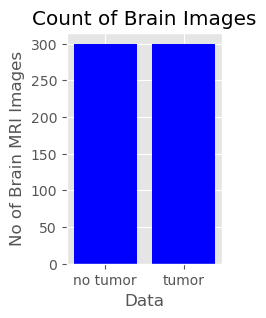

In [23]:
#plotting the yes and no data
fig = plt.figure(figsize=(2,3))
plt.bar(['no tumor','tumor'],[no_files_no,no_files_yes],color='blue')
plt.xlabel('Data')
plt.ylabel('No of Brain MRI Images')
plt.title('Count of Brain Images')

**Plotting the Brain MRI images**

In [24]:
'''
This function takes the name of the folder in Dataset directory and shows 7x7 = 49 images in the folder
'''
def plot_Brain_images(folder):
    fig, axes = plt.subplots(7,7,figsize=(10,10))
    for ax in axes.flatten():
        path = f'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/Dataset/{folder}/*.jpg'
        #Read all the files' path present in "path" directory
        paths = glob.glob(path)
        #select the random file path
        p = random.choice(paths)
        #Get the path with semantics appropriate for underlying OS
        p=pathlib.Path(p)
        #load images
        img = load_img(p)
        #plot the image
        ax.imshow(img)
        #set image properties
        ax.tick_params(left=False,right=False,labelleft=False,labelbottom=False,bottom=False)

   #Use different image title for tumor and no tumor images
    if folder == 'yes':
        fig.suptitle('Brain MRI Images\n(Tumorous)',fontsize=16)
    else:
        fig.suptitle('Brain MRI Images\n(Non Tumorous)',fontsize=16)

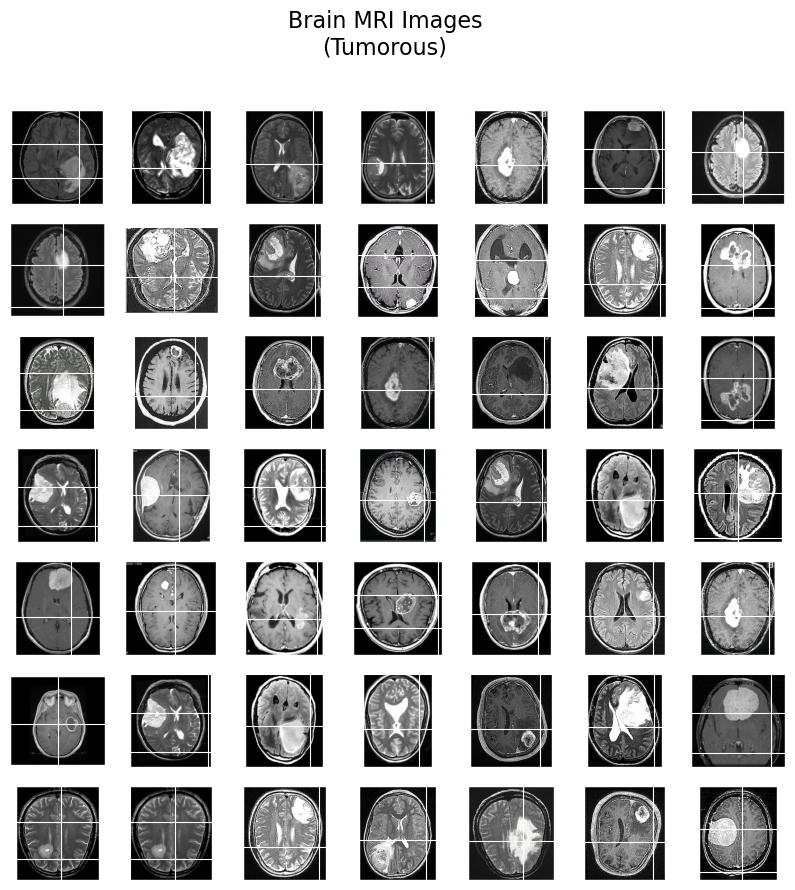

In [25]:
#plot random images of Tumorous images
plot_Brain_images('yes')

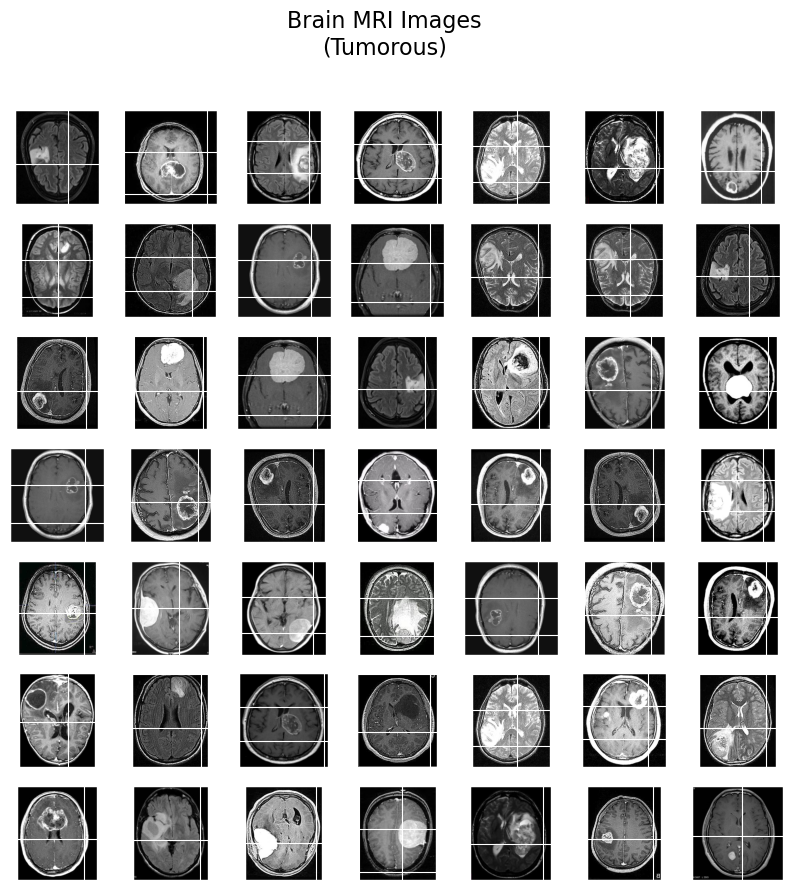

In [26]:
#plot random images of non Tumorous images
plot_Brain_images('yes')

## ***Data PreProcessing***
<li>Image Contouring</li>
<li>Image Resizing</li>

In [27]:
'''
If we see the images, there is lots of extra pixels so wee have to find the contour of the image and crop the image and resize it
The bellow function do exactly that
'''
def crop_process_image(image,image_width,image_height):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (5,5), 0)

    thres = cv2.threshold(gray_image, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    new_image = cv2.resize(new_image, dsize=(image_width,image_height), interpolation = cv2.INTER_CUBIC)

    return new_image

In [28]:
#cropping and processing all the images and saving them
path_yes = 'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/Dataset/yes/'
path_no = 'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/Dataset/no/'

# for the actual files in yes directory
for filename in os.listdir(path_yes):
    img = cv2.imread(path_yes+filename)
    img = crop_process_image(img, image_width=240, image_height=240)
    cv2.imwrite(path_yes+filename, img)

#for the actual files in no directory
for filename in os.listdir(path_no):
    img = cv2.imread(path_no+filename)
    img = crop_process_image(img, image_width=240, image_height=240)
    cv2.imwrite(path_no+filename, img)

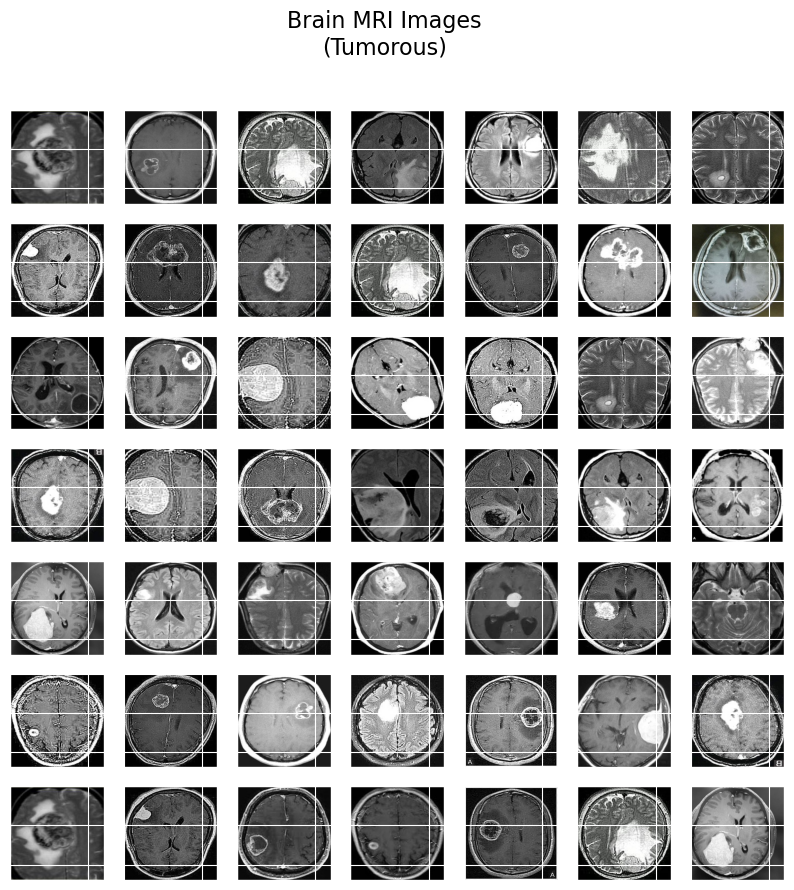

In [29]:
#now plot the cropped images
plot_Brain_images('yes')

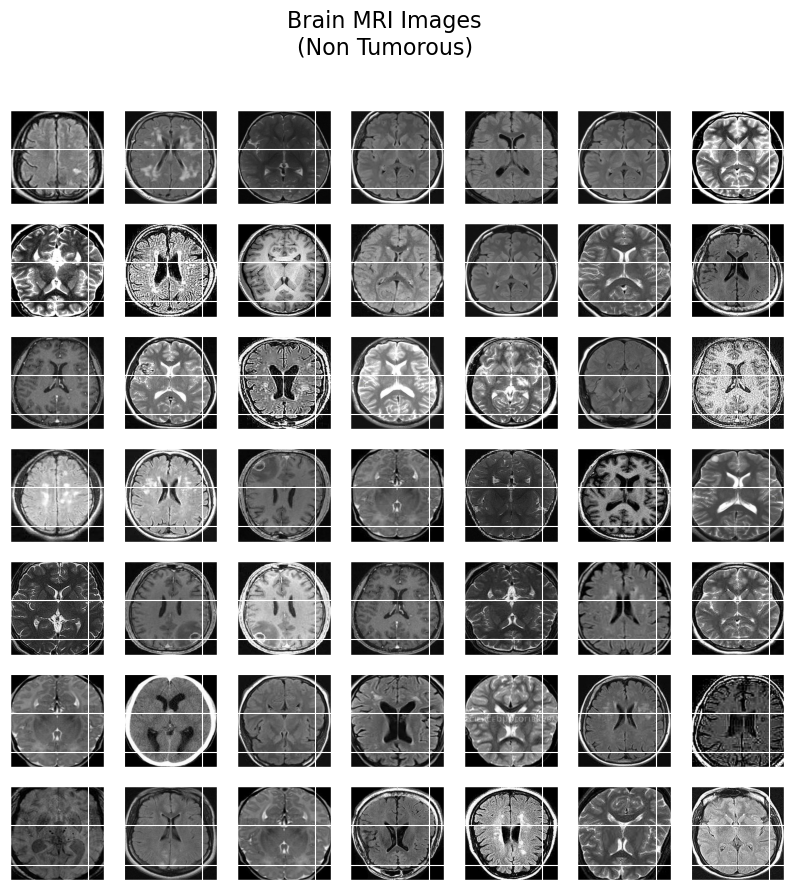

In [30]:
plot_Brain_images('no')

## ***Load Images in different Directories***

In [31]:
"""
This function returns two lists containing the paths
of all the images of tumorous and non tumorous.
"""
def get_image_path_list():
    #Create empty lists to store the paths of class 0 and class 1 images
    tumorous = []
    non_tumorous = []

    #Read tumorous and non tumorous images paths
    tumorous_yes = glob.glob('C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/Dataset/yes/*.jpg')
    tumorous_no = glob.glob('C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/Dataset/no/*.jpg')

    tumorous.extend(tumorous_yes)
    non_tumorous.extend(tumorous_no)

    #shuffle the paths lists randomly
    random.shuffle(tumorous)
    random.shuffle(non_tumorous)

    return tumorous, non_tumorous

In [32]:
"""
This function accepts the "train_split" value from the range [0,1]
and based on that, splits the images into training and testing directories
for model training and evaluation.

"""
def create_dataset(train_split = 0.80):
    #Use the "get_image_path_list" function to get two separate lists
    # of all the images of tumorous and non tumorous brain
    tumorous, non_tumorous = get_image_path_list()

    #calculate total number of images of both class
    total_tumorous = len(tumorous)
    total_non_tumorous = len(non_tumorous)

    #Calculate the number of images for train dataset for both classes
    total_tumorous_train = int(total_tumorous * train_split)
    total_non_tumorous_train = int(total_non_tumorous * train_split)

    #Create sub-directories for train directory
    train_yes_dir = 'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/new_dataset/train/1'
    train_no_dir = 'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/new_dataset/train/0'
    os.makedirs(train_yes_dir)
    os.mkdir(train_no_dir)

    #Create sub-directories for test directory
    test_yes_dir = 'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/new_dataset/test/1'
    test_no_dir = 'C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/new_dataset/test/0'
    os.makedirs(test_yes_dir)
    os.mkdir(test_no_dir)

    #Let's copy the image of tumorous
    for i in range(total_tumorous):
        path = tumorous[i]
        #if the index of the current image is less then the validation threshold then, we'll copy
        #the image to the train directory, otherwise to test directory
        if i<total_tumorous_train:
            shutil.copy(src=path, dst=train_yes_dir)
        else:
            shutil.copy(src=path, dst=test_yes_dir)

    #Let's copy the image of non tumorous
    for i in range(total_non_tumorous):
        path = non_tumorous[i]
        #if the index of the current image is less then the validation threshold then, we'll copy
        #the image to the train directory, otherwise to test directory
        if i<total_non_tumorous_train:
            shutil.copy(src=path, dst=train_no_dir)
        else:
            shutil.copy(src=path, dst=test_no_dir)

In [33]:
#Create the dataset using the function create_dataset()
# with 80% data for training and 20% for testing
create_dataset(train_split=0.80)

In [34]:
#To ensure that the function worked properly, we can check the size of trainning dataset
tumorous, non_tumorous = get_image_path_list()

print("Size of 80% images of tumorous =", int(len(tumorous)*0.80))
print("Size of 80% images of non tumorous =", int(len(non_tumorous)*0.80))
print("Size of 80% images of class both classes =", int(len(tumorous)*0.80) + int(len(non_tumorous)*0.80))

train_data_size = glob.glob("C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/new_dataset/train/**/*.jpg")
print("Size of training dataset =",len(train_data_size))

Size of 80% images of tumorous = 240
Size of 80% images of non tumorous = 240
Size of 80% images of class both classes = 480
Size of training dataset = 480


In [35]:
print(len(os.listdir('C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/new_dataset/train/1')))
print(len(os.listdir('C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/new_dataset/train/0')))

240
240
